In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy   
import random
from sklearn.preprocessing import normalize

from collections import Counter
from scipy.stats import mode

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [5]:
# Define file paths
model_path = r'C:\Users\k54739\saved_model\ohneContrastSweetcrop_simclr_model_epoch_245.pth'
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4)
simclr_model.load_state_dict(torch.load(model_path))
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_17764\2485837486.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# Clustering

In [6]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        #self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        #return image, label
        return image, label, img_path

def load_data(root_dir):
    #classes = ['cond7_all', 'sd','ex'] #full dataset
    #classes = ['cond7_curated', 'sd','ex'] # curated full dataset


    #classes = ['cure_cond7_40', 'sdonly_40','ex'] # 40 subset
    classes = ['cond7_all', 'sd','ex']


   
    
    #classes = ['curated_cond7_40', 'sd_40','ex'] # curated 40 subset


    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})

    return image_files, labels


# Directories for labeled data
#image_dir =  r"C:\Users\k54739\Bibi_new_thesis\thesis\classification"

image_dir =  r"G:\classification\cond_all"


# Load data
image_files, labels = load_data(image_dir)

# Create the labeled datasets
labeled_dataset = LabeledImageDataset(image_files, labels)

# Define DataLoaders
batch_size = 16
loader_labeled = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)

Label distribution: {'cond7_all': 472, 'sd': 103, 'ex': 40}


In [7]:
# Print label mapping
classes = ['cond7_all', 'sd','ex']
for idx, class_name in enumerate(classes):
    print(f"Label {idx} corresponds to class: {class_name}")

Label 0 corresponds to class: cond7_all
Label 1 corresponds to class: sd
Label 2 corresponds to class: ex


In [8]:
label_mapping = {idx: class_name for idx, class_name in enumerate(classes)}
print("Label mapping:", label_mapping)

Label mapping: {0: 'cond7_all', 1: 'sd', 2: 'ex'}


In [9]:
for anchor,label,path in loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    print(path)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2])
['G:\\classification\\cond_all\\cond7_all\\ds_1B_E07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_C02-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds62_g9_C09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_F07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_D07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_E03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_D03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_C02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_G05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_E04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_G09-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds62_g8_B07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_E07-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g9_C09-T01.tiff', 'G:\\classificat

In [10]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    #network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels, paths = [], [], []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        print(f"Batch labels shape: {batch_paths}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)
        paths.extend(batch_paths) 

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")
    print(f"Number of paths after concatenation: {len(paths)}")

    return feats, labels, paths

In [11]:
# Extract features for train and test datasets
feats, labels, paths = prepare_data_features(simclr_model, loader_labeled)

  3%|▎         | 1/39 [00:00<00:29,  1.27it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\sd\\RBT09_F07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_E08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_F10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_B10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_F08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_F10-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds62_g9_C09-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_G08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_B05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_C08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_F08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_D08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_D11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_F10-T01.tiff', 'G:\\classification\\cond_all\\cond7

  5%|▌         | 2/39 [00:01<00:26,  1.38it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_41_G07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_E04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_E02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_D11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_C05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_D11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_C11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_E04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_E07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_B05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_C07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_G03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_C11-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_F10-T01.tiff', 'G:\\classification\\con

  8%|▊         | 3/39 [00:02<00:25,  1.44it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\sd_04_F02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_C07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_D11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_F08-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT14_D11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_F08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_G02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_E11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_B05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_F04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_B11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_E05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_F06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_C09-T01.tiff', 'G:\\classification\\con

 10%|█         | 4/39 [00:02<00:23,  1.47it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_52_G08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_C06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_G11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_G05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_C08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_D02-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_C08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_D04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_E08-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_D07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_B04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_F02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_E02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_G08-T01.tiff', 'G:\\classification\\cond_all\\

 13%|█▎        | 5/39 [00:03<00:22,  1.49it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_52_B04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_B07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_C10-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_E11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_E04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_D07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_B07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_G10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_F09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_B06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_F07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_G06-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT14_C09-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT14_D08-T01.tiff', 'G:\\classification\\cond_all\\cond7_a

 15%|█▌        | 6/39 [00:04<00:22,  1.49it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\sd_04_D02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_G09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_C06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_C08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_G05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_D11-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g3_C05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_G05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_D10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_G11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_G04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_C11-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_D09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_C02-T01.tiff', 'G:\\classification\\cond_all

 18%|█▊        | 7/39 [00:04<00:21,  1.47it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\sd\\RBT04_C09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_D10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_D06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_F04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_E11-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_E09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_D04-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds1B_g9_C8.tif', 'G:\\classification\\cond_all\\cond7_all\\ds_62_G09-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT14_D10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_B07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_G04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_E11-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_G08-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT14_D09-T01.tiff', 

 21%|██        | 8/39 [00:05<00:20,  1.49it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_51_B09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_B06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_G08-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_E07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_C09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_E10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_G04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_D09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_B03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_B02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_B04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_F03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_B04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_G07-T01.tiff', 'G:\\classification\\con

 23%|██▎       | 9/39 [00:06<00:20,  1.49it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\ex\\ds61_g6_F02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_E05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_G03-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds62_g8_B09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_G04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_F02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_D05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_G05-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds62_g9_C08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_B02-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_C09-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds62_g8_B07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_B05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_G08-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_F08

 26%|██▌       | 10/39 [00:06<00:19,  1.49it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\sd\\RBT10_F07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_C10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_C02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_E02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_C06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_C09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_C10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_F07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_E02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_F04-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_F11-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_B08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_G04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_F05-T01.tiff', 'G:\\classification\\cond_all\\cond7_a

 28%|██▊       | 11/39 [00:07<00:18,  1.51it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_1B_B08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_G05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_E06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_E10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_C09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_C06-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_E07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_E09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_G06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_D04-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_C08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_E05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_D03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_E10-T01.tiff', 'G:\\classification\\cond_all\\

 31%|███       | 12/39 [00:08<00:18,  1.47it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\sd\\RBT09_E11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_B07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_B03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_D04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_C04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_G05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_E08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_E08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_E11-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_D11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_C10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_D10-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds41_g9_C10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_E11-T01.tiff', 'G:\\classification\\cond_all\\sd\\R

 33%|███▎      | 13/39 [00:08<00:17,  1.46it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_51_C06-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g6_F06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_C04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_B03-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_G07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_C08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_F03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_B10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_B03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_E07-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_G09-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g9_C08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_E06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_D11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\

 36%|███▌      | 14/39 [00:09<00:17,  1.44it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_52_D09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_B10-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g8_B10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_B03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_D06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_F07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_B09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_D10-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_B09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_C04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_E09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_D09-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_B11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_E05-T01.tiff', 'G:\\classification\\cond_all\\sd\\R

 38%|███▊      | 15/39 [00:10<00:16,  1.43it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\ex\\ds1B_g9_c10.tif', 'G:\\classification\\cond_all\\cond7_all\\ds_42_B04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_F11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_D05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_G07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_E09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_G07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_D08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_B06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_E09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_B02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_C06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_F07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_F03-T01.tiff', 'G:\\classification\\cond_a

 41%|████      | 16/39 [00:10<00:16,  1.44it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\sd_04_F06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_D03-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds41_g3_C05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_C10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_E11-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_G07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_E03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_G11-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds62_g8_B11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_C05-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_B11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_C10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_F08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_E02-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_

 44%|████▎     | 17/39 [00:11<00:15,  1.43it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\sd\\RBT04_F09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_G04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_D10-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_C09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_G06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_F11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_C08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_C08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_B06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_B09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_C02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_G07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_D07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_G09-T01.tiff', 'G:\\classification\\cond_all\\

 46%|████▌     | 18/39 [00:12<00:14,  1.43it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_51_B05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_D02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_C10-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_B07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_F11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_C07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_F09-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_E10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_D03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_D07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_F11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_E05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_F05-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_G11-T01.tiff', 'G:\\classification\\cond_all\\cond7_a

 49%|████▊     | 19/39 [00:13<00:13,  1.44it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_62_F10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_D06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_G11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_D07-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT14_B11-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds41_g3_C02-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds1B_g9_C11.tif', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_F09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_B07-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g8_B07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_F09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_C09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_G08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_E08-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_D10

 51%|█████▏    | 20/39 [00:13<00:13,  1.42it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\sd\\RBT09_C07-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_D09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_D09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_B06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_G08-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_D11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_D02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_F11-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g6_F05-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT14_B08-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds62_g9_C11-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT14_C08-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g9_C11-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g3_C04-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g8_B11-T01.tiff', 'G:\\classific

 54%|█████▍    | 21/39 [00:14<00:12,  1.43it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_51_G09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_B11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_C11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_D02-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_C10-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds41_g3_C03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_B06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_F11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_C03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_G02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_C03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_C05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_B08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_C04-T01.tiff', 'G:\\classification\\cond_all

 56%|█████▋    | 22/39 [00:15<00:11,  1.44it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_42_G07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_F11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_D07-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_D09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_C09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_F04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_E10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_C09-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_F08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_E02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_D06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_G05-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_B10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_D06-T01.tiff', 'G:\\classification\\cond_all\\cond7_a

 59%|█████▉    | 23/39 [00:15<00:11,  1.41it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_52_B03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_C02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_C11-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_F10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_B09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_G04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_F05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_E06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_E02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_B08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_G10-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT14_D07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_C07-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_F07-T01.tiff', 'G:\\classification\\cond_all\\cond7_a

 62%|██████▏   | 24/39 [00:16<00:10,  1.42it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_42_E10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_G03-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds41_g3_C06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_E06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_F05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_B03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_B10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_D08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_B08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_B11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_C02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_B05-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds41_g3_C04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_G02-T01.tiff', 'G:\\classification\\cond_a

 64%|██████▍   | 25/39 [00:17<00:09,  1.41it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\sd\\RBT04_B07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_D10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_F02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_C04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_B04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_E10-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_D10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_F11-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT14_B07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_G07-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds1B_g9_C7.tif', 'G:\\classification\\cond_all\\cond7_all\\sd_04_F05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_D02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_D02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_C

 67%|██████▋   | 26/39 [00:18<00:09,  1.43it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_42_D03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_E09-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_F09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_C09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_D07-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_G11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_C03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_B11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_E08-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_B09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_E09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_B10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_E09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_F02-T01.tiff', 'G:\\classification\\cond_all\\cond7_a

 69%|██████▉   | 27/39 [00:18<00:08,  1.43it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_51_F02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_F04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_C05-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds62_g9_C10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_G09-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_G10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_F04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_E04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_E08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_D11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_B09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_C07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_F10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_B07-T01.tiff', 'G:\\classification\\cond_all

 72%|███████▏  | 28/39 [00:19<00:07,  1.44it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_42_D04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_E03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_F06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_D07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_F06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_C03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_C05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_B02-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g3_C02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_G10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_F07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_F02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_D04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_B02-T01.tiff', 'G:\\classification\\c

 74%|███████▍  | 29/39 [00:20<00:06,  1.44it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_51_G03-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g9_C09-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT14_C07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_F06-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT14_C10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_B02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_D05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_B07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_F10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_C06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_C03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_F03-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g6_F04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_E03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\

 77%|███████▋  | 30/39 [00:20<00:06,  1.43it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_61_B09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_C11-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g9_C10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_D05-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_F11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_D04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_F03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_B08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_D08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_D08-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds62_g8_B10-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_E08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_E08-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_C10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_

 79%|███████▉  | 31/39 [00:21<00:05,  1.45it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_42_F05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_G07-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_E10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_E03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_G09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_D08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_F09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_E04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_C05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_E05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_F06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_C05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_E09-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_G07-T01.tiff', 'G:\\classification\\cond_all\\

 82%|████████▏ | 32/39 [00:22<00:04,  1.44it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\ex\\ds61_g8_B09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_C05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_B10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_F02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_C10-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_E11-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_F09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_D06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_D05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_F07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_C03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_B03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_F05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_F08-T01.tiff', 'G:\\classification\\cond_all\\cond7

 85%|████████▍ | 33/39 [00:22<00:04,  1.44it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\sd_04_E07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_F04-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_E09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_C07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_E07-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_E08-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_G09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_D03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_C11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_B06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_D04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_F09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_G03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_D09-T01.tiff', 'G:\\classification\\cond_all\\cond7_a

 87%|████████▋ | 34/39 [00:23<00:03,  1.44it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_61_G06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_B11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_C07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_G11-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_C07-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g9_C07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_B06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_E07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_D10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_G02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_E03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_B10-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_B08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_E05-T01.tiff', 'G:\\classification\\cond_all\\cond7

 90%|████████▉ | 35/39 [00:24<00:02,  1.44it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_41_G11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_B08-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds62_g9_C07-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_D08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_D09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_F06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_G02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_E07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_E11-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_C07-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_B10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_E04-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_D02-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_G09-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g8_B08-T01

 92%|█████████▏| 36/39 [00:24<00:02,  1.45it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_61_F10-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g6_F03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_B11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_C02-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_G08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_D03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_E03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_D10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_G09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_F07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_C03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_D05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_G06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_F03-T01.tiff', 'G:\\classification\\cond_all

 95%|█████████▍| 37/39 [00:25<00:01,  1.45it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\sd\\RBT10_C11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_E10-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_E09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_B05-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_D07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_1B_C04-T01.tiff', 'G:\\classification\\cond_all\\ex\\ds61_g3_C06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_F07-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_C11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_G06-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_B08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_C07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_51_F08-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_G10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_61_G05-T01.tiff', '

 97%|█████████▋| 38/39 [00:26<00:00,  1.44it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Batch labels shape: ['G:\\classification\\cond_all\\cond7_all\\ds_52_G02-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_D09-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_E07-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT14_B10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_B10-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT10_G11-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_G10-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT04_E10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_42_E07-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_G10-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_62_D05-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_D09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_F09-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_D03-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_

100%|██████████| 39/39 [00:26<00:00,  1.46it/s]

Batch features shape: torch.Size([7, 20])
Batch labels shape: torch.Size([7])
Batch labels shape: ['G:\\classification\\cond_all\\sd\\RBT10_D08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\sd_04_B08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_D06-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_41_B11-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT14_C11-T01.tiff', 'G:\\classification\\cond_all\\sd\\RBT09_D08-T01.tiff', 'G:\\classification\\cond_all\\cond7_all\\ds_52_E03-T01.tiff']
Features shape after concatenation: torch.Size([615, 20])
Labels shape after concatenation: torch.Size([615])
Number of paths after concatenation: 615


import umap
import matplotlib.pyplot as plt
import numpy as np

# Assuming feats is a tensor of shape (N, feature_size), where N is the number of samples and feature_size is the dimensionality of the features
# You can reduce the dimensionality of feats with UMAP

# Convert feats to numpy array
feats_np = feats.detach().cpu().numpy()

# 2D UMAP projection
umap_2d = umap.UMAP(n_components=2, random_state=42)
feats_2d = umap_2d.fit_transform(feats_np)

# 1D UMAP projection
umap_1d = umap.UMAP(n_components=1, random_state=42)
feats_1d = umap_1d.fit_transform(feats_np)

# Plot 2D UMAP
plt.figure(figsize=(10, 6))
plt.scatter(feats_2d[:, 0], feats_2d[:, 1], c=labels, cmap='viridis', edgecolors='k', s=50)
plt.colorbar(label='Class Label')
plt.title('2D UMAP projection of features')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Plot 1D UMAP
plt.figure(figsize=(10, 6))
plt.scatter(feats_1d, np.zeros_like(feats_1d), c=labels, cmap='viridis', edgecolors='k', s=50)
plt.colorbar(label='Class Label')
plt.title('1D UMAP projection of features')
plt.xlabel('UMAP 1D')
plt.yticks([])  # Hide the y-axis ticks since it's all zeros
plt.show()


import numpy as np
import matplotlib.pyplot as plt
import umap

# Assuming feats_np and labels are already defined from your UMAP pipeline
# For example:
# feats_np = ...   # Your features in NumPy format
# labels = ...     # Corresponding class labels (e.g., 0, 1, 2)

# 1D UMAP projection
umap_1d = umap.UMAP(n_components=1, random_state=42)
feats_1d = umap_1d.fit_transform(feats_np)  # feats_1d shape: (N, 1)

# Plot 1D UMAP with y-axis set to the class labels
plt.figure(figsize=(10, 6))
plt.scatter(feats_1d[:, 0], labels, c=labels, cmap='viridis', edgecolors='k', s=50)
plt.colorbar(label='Class Label')
plt.title('1D UMAP Projection with Class Separation')
plt.xlabel('UMAP 1D')
plt.ylabel('Class Label')
plt.yticks(np.unique(labels))  # Ensure y-axis ticks match the unique class labels
plt.show()

# -----------------------------------------------
# Step 1: Compute mean, min, and max UMAP values for each class
# -----------------------------------------------
unique_classes = np.unique(labels)
class_means = {}
class_min_max = {}

for cls in unique_classes:
    # Extract UMAP values for the current class
    cls_indices = np.where(labels == cls)[0]
    cls_umap_values = feats_1d[cls_indices, 0]
    # Compute mean, min, and max for the class
    class_means[cls] = np.mean(cls_umap_values)
    class_min_max[cls] = {
        'min': np.min(cls_umap_values),
        'max': np.max(cls_umap_values)
    }

# Print the mean UMAP value for each class
print("Mean UMAP value for each class:")
for cls in unique_classes:
    print(f"Class {cls}: {class_means[cls]:.4f}")

# -----------------------------------------------
# Print min and max UMAP values for all classes
# -----------------------------------------------
print("\nMin and Max UMAP values for each class:")
for cls in unique_classes:
    print(f"Class {cls}: min = {class_min_max[cls]['min']:.4f}, max = {class_min_max[cls]['max']:.4f}")

# -----------------------------------------------
# Step 2: Determine the middle class (median mean)
# -----------------------------------------------
# Sort classes by their mean UMAP value
sorted_classes = sorted(class_means.keys(), key=lambda x: class_means[x])
# For three classes, the one at index 1 is the middle class
middle_class = sorted_classes[1]
print(f"\nMiddle Class (by mean UMAP value): {middle_class}")

middle_min = class_min_max[middle_class]['min']
middle_max = class_min_max[middle_class]['max']
print(f"Middle class UMAP range: {middle_min:.4f} to {middle_max:.4f}")

# -----------------------------------------------
# Step 3: Count misclassified points from the first class
# (Points from first class that exceed the minimum of the middle class)
# -----------------------------------------------
first_class = sorted_classes[0]
first_cls_indices = np.where(labels == first_class)[0]
first_cls_umap = feats_1d[first_cls_indices, 0]
# Count how many first class points are greater than middle_min
count_first_exceed = np.sum(first_cls_umap > middle_min)
print(f"\nNumber of data points from first class (class {first_class}) that passed the minimum UMAP value of the middle class: {count_first_exceed}")

# -----------------------------------------------
# Step 4: Count misclassified points from the third class
# (Points from third class that are below the maximum of the middle class)
# -----------------------------------------------
third_class = sorted_classes[2]
third_cls_indices = np.where(labels == third_class)[0]
third_cls_umap = feats_1d[third_cls_indices, 0]
# Count how many third class points are less than middle_max
count_third_before = np.sum(third_cls_umap < middle_max)
print(f"Number of data points from third class (class {third_class}) that lie before the maximum UMAP value of the middle class: {count_third_before}")

# -----------------------------------------------
# Step 5: Compute Accuracy
# Accuracy = (total datapoints - misclassified points from first and third classes) / total datapoints
# -----------------------------------------------
total_misclassified = count_first_exceed + count_third_before
total_datapoints = feats_1d.shape[0]
accuracy = (total_datapoints - total_misclassified) / total_datapoints
print(f"\nAccuracy: {accuracy:.4f}")


tsne

Running t-SNE...


c:\Users\k54739\.conda\envs\master\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


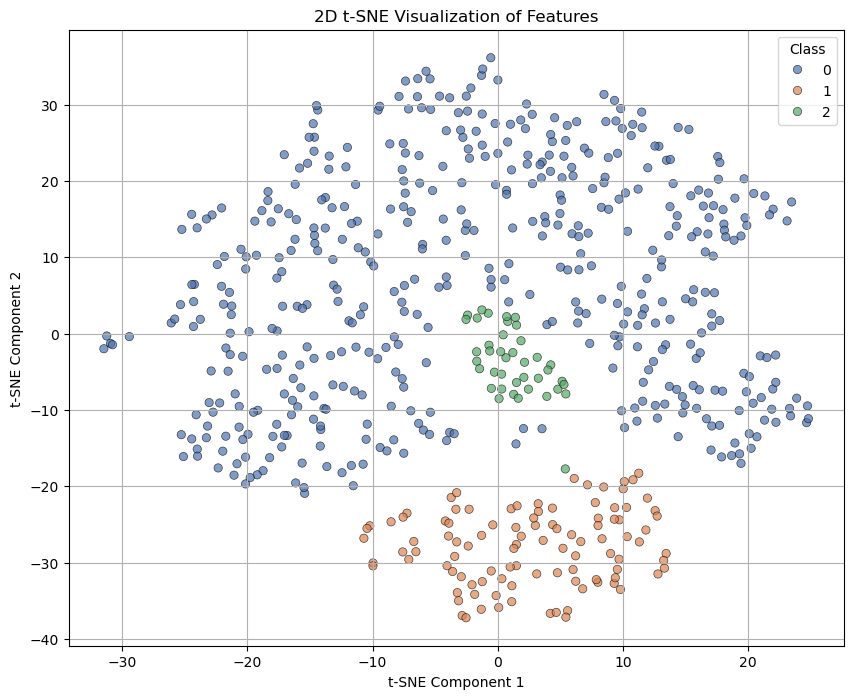

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

# Perform t-SNE
perplexity = 30  # You can tune this parameter
n_iter = 1000  # Number of iterations for optimization

# Convert features to NumPy array if they are in tensor form
feats_np = feats.numpy() if isinstance(feats, torch.Tensor) else feats
labels_np = labels.numpy() if isinstance(labels, torch.Tensor) else labels

# Apply t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
feats_2d = tsne.fit_transform(feats_np)

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=feats_2d[:, 0], y=feats_2d[:, 1], hue=labels_np, palette="deep", alpha=0.7, edgecolors='k')
plt.title("2D t-SNE Visualization of Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class", loc='best')
plt.grid(True)
plt.show()


Running t-SNE...


c:\Users\k54739\.conda\envs\master\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


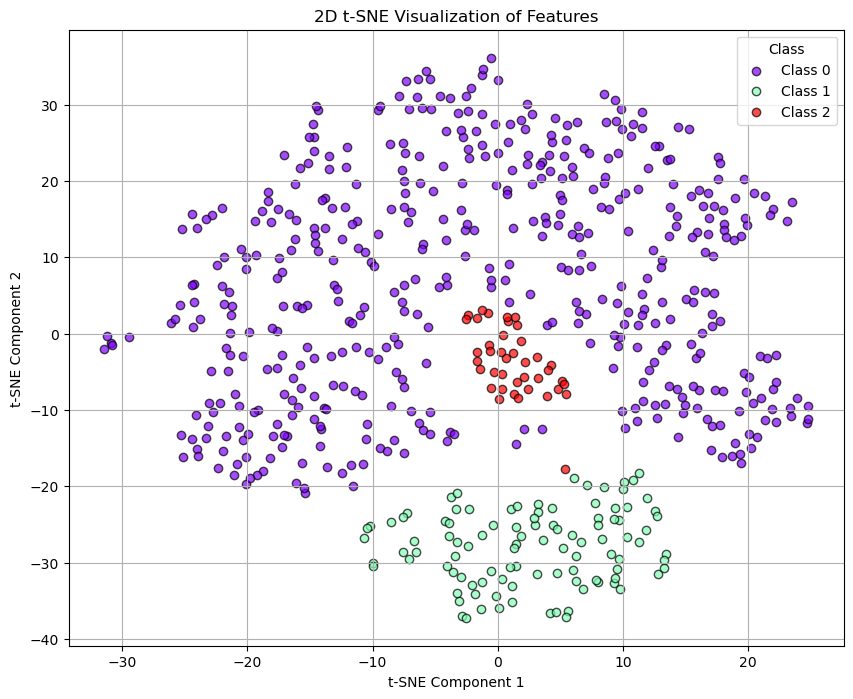

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

# Perform t-SNE
perplexity = 30  # You can tune this parameter
n_iter = 1000  # Number of iterations for optimization

# Convert features to NumPy array if they are in tensor form
feats_np = feats.numpy() if isinstance(feats, torch.Tensor) else feats
labels_np = labels.numpy() if isinstance(labels, torch.Tensor) else labels

# Apply t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
feats_2d = tsne.fit_transform(feats_np)

# Define colors for the different classes
num_classes = len(np.unique(labels_np))
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

# Create a scatter plot
plt.figure(figsize=(10, 8))
for i, color in zip(np.unique(labels_np), colors):
    plt.scatter(feats_2d[labels_np == i, 0], feats_2d[labels_np == i, 1], label=f'Class {i}', color=color, alpha=0.7, edgecolors='k')

plt.title("2D t-SNE Visualization of Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class", loc='best')
plt.grid(True)
plt.show()


Running 1D t-SNE...


c:\Users\k54739\.conda\envs\master\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Paths and t-SNE Scores (Ascending Order):
G:\classification\cond_all\cond7_all\ds_61_B11-T01.tiff: -26.7880
G:\classification\cond_all\cond7_all\ds_62_D11-T01.tiff: -26.7860
G:\classification\cond_all\cond7_all\ds_62_B02-T01.tiff: -26.7846
G:\classification\cond_all\cond7_all\ds_61_B02-T01.tiff: -26.7691
G:\classification\cond_all\cond7_all\ds_61_G07-T01.tiff: -26.7576
G:\classification\cond_all\cond7_all\ds_1B_B03-T01.tiff: -24.7660
G:\classification\cond_all\cond7_all\ds_42_G04-T01.tiff: -24.4145
G:\classification\cond_all\cond7_all\ds_42_F02-T01.tiff: -24.2894
G:\classification\cond_all\cond7_all\ds_42_B11-T01.tiff: -23.9966
G:\classification\cond_all\cond7_all\ds_42_B08-T01.tiff: -23.8823
G:\classification\cond_all\cond7_all\ds_42_F04-T01.tiff: -23.8223
G:\classification\cond_all\cond7_all\ds_42_G05-T01.tiff: -23.8039
G:\classification\cond_all\cond7_all\ds_42_C07-T01.tiff: -23.7284
G:\classification\cond_all\cond7_all\ds_1B_B04-T01.tiff: -23.2936
G:\classification\cond_all\cond7_

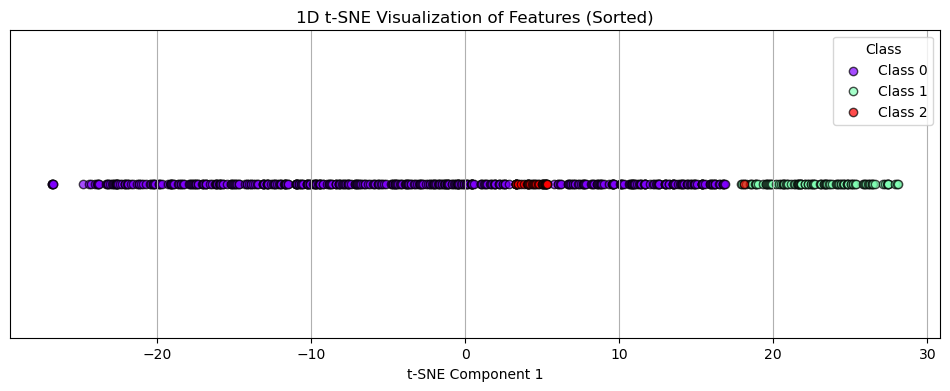

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# Perform t-SNE
perplexity = 30  # Tune as needed
n_iter = 1000  # Number of optimization iterations

# Convert features to NumPy array if they are in tensor form
feats_np = feats.numpy() if isinstance(feats, torch.Tensor) else feats
labels_np = labels.numpy() if isinstance(labels, torch.Tensor) else labels

# Apply 1D t-SNE
print("Running 1D t-SNE...")
tsne = TSNE(n_components=1, perplexity=perplexity, n_iter=n_iter, random_state=42)
feats_1d = tsne.fit_transform(feats_np).flatten()  # Flatten to 1D array

# Sort paths and scores in ascending order of t-SNE scores
sorted_indices = np.argsort(feats_1d)  # Get indices that would sort the scores
sorted_paths = np.array(paths)[sorted_indices]
sorted_scores = feats_1d[sorted_indices]

# Print sorted paths with corresponding t-SNE scores
print("\nPaths and t-SNE Scores (Ascending Order):")
for path, score in zip(sorted_paths, sorted_scores):
    print(f"{path}: {score:.4f}")

# Define colors for the different classes
num_classes = len(np.unique(labels_np))
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

# Create a scatter plot in 1D
plt.figure(figsize=(12, 4))
for i, color in zip(np.unique(labels_np), colors):
    plt.scatter(sorted_scores[labels_np[sorted_indices] == i], 
                np.zeros_like(sorted_scores[labels_np[sorted_indices] == i]), 
                label=f'Class {i}', color=color, alpha=0.7, edgecolors='k')

plt.title("1D t-SNE Visualization of Features (Sorted)")
plt.xlabel("t-SNE Component 1")
plt.yticks([])  # Remove y-axis ticks for clarity
plt.legend(title="Class", loc='best')
plt.grid(axis='x')
plt.show()


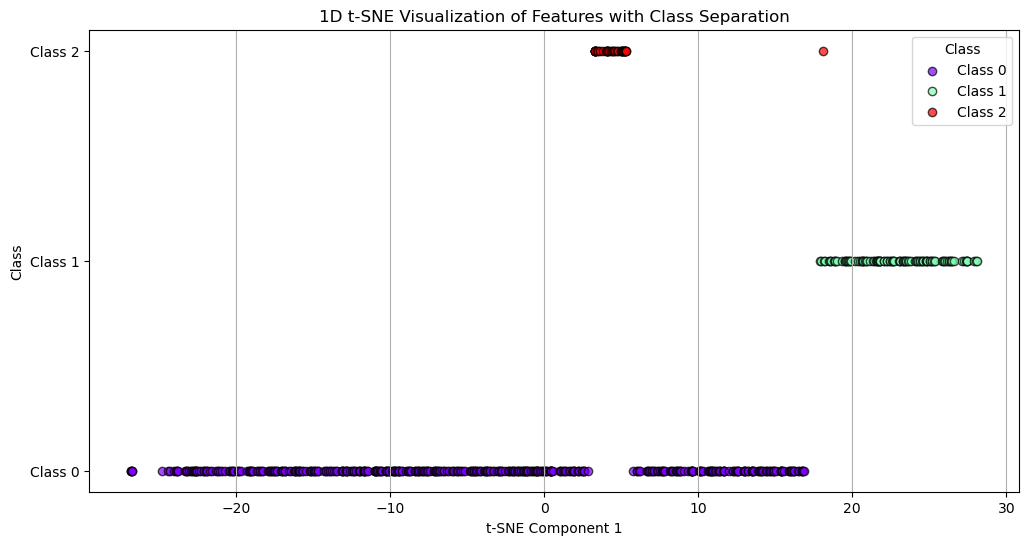

In [15]:
# Define y-positions for each class
unique_classes = np.unique(labels_np)
class_y_positions = {cls: i for i, cls in enumerate(unique_classes)}

# Create a scatter plot in 1D with y-positions for each class
plt.figure(figsize=(12, 6))
for cls, color in zip(unique_classes, colors):
    class_indices = labels_np[sorted_indices] == cls
    plt.scatter(
        sorted_scores[class_indices],
        np.full_like(sorted_scores[class_indices], class_y_positions[cls]),  # Assign y-position based on class
        label=f'Class {cls}',
        color=color,
        alpha=0.7,
        edgecolors='k'
    )

plt.title("1D t-SNE Visualization of Features with Class Separation")
plt.xlabel("t-SNE Component 1")
plt.ylabel("Class")
plt.yticks(range(len(unique_classes)), [f"Class {cls}" for cls in unique_classes])  # Set y-ticks for classes
plt.legend(title="Class", loc='best')
plt.grid(axis='x')
plt.show()


In [16]:
# Step 1: Find the mean value of t-SNE 1D for each class
means_tsne = {cls: sorted_scores[labels_np[sorted_indices] == cls].mean() for cls in unique_classes}
print("\nMean t-SNE 1D values for each class:")
for cls, mean_value in means_tsne.items():
    print(f"Class {cls}: {mean_value:.4f}")

# Step 2: Find the middle class (class with median mean value of t-SNE 1D)
sorted_means = sorted(means_tsne.items(), key=lambda x: x[1])
middle_class = sorted_means[1][0]  # Middle class in sorted order
print(f"\nMiddle class based on mean t-SNE 1D value: Class {middle_class}")

# Step 3: Find the min and max value of t-SNE 1D for each class
min_max_tsne = {
    cls: (sorted_scores[labels_np[sorted_indices] == cls].min(), 
          sorted_scores[labels_np[sorted_indices] == cls].max())
    for cls in unique_classes
}
print("\nMin and Max t-SNE 1D values for each class:")
for cls, (min_value, max_value) in min_max_tsne.items():
    print(f"Class {cls}: Min={min_value:.4f}, Max={max_value:.4f}")

# Step 4: Number of data points from first class (least mean value) passing min value of middle class
first_class = sorted_means[0][0]  # Class with least mean value
min_middle_class = min_max_tsne[middle_class][0]
first_class_passed = np.sum(sorted_scores[labels_np[sorted_indices] == first_class] > min_middle_class)
print(f"\nNumber of data points from Class {first_class} passing min value of middle class: {first_class_passed}")

# Step 5: Number of data points from third class (highest mean value) before max value of middle class
third_class = sorted_means[2][0]  # Class with highest mean value
max_middle_class = min_max_tsne[middle_class][1]
third_class_before = np.sum(sorted_scores[labels_np[sorted_indices] == third_class] < max_middle_class)
print(f"Number of data points from Class {third_class} before max value of middle class: {third_class_before}")

# Step 6: Calculate accuracy
total_points = len(labels_np)
incorrect_points = first_class_passed + third_class_before
accuracy = (total_points - incorrect_points) / total_points
print(f"\nAccuracy: {accuracy:.4f}")



Mean t-SNE 1D values for each class:
Class 0: -4.1149
Class 1: 22.8786
Class 2: 4.7140

Middle class based on mean t-SNE 1D value: Class 2

Min and Max t-SNE 1D values for each class:
Class 0: Min=-26.7880, Max=16.8765
Class 1: Min=17.9145, Max=28.0759
Class 2: Min=3.2742, Max=18.1229

Number of data points from Class 0 passing min value of middle class: 133
Number of data points from Class 1 before max value of middle class: 2

Accuracy: 0.7805


import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Convert PyTorch tensors to NumPy arrays
feats_np = feats.numpy()
labels_np = labels.numpy()

# Standardize features before PCA
scaler = StandardScaler()
feats_scaled = scaler.fit_transform(feats_np)

# Apply PCA
pca = PCA(n_components=2)
feats_pca = pca.fit_transform(feats_scaled)

# Plot PCA results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feats_pca[:, 0], feats_pca[:, 1], c=labels_np, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of SimCLR Features')
plt.show()


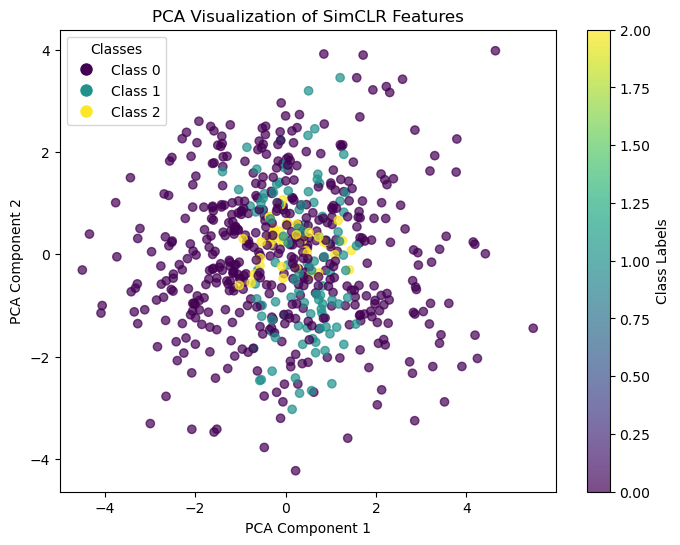

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Convert PyTorch tensors to NumPy arrays
feats_np = feats.numpy()
labels_np = labels.numpy()

# Standardize features before PCA
scaler = StandardScaler()
feats_scaled = scaler.fit_transform(feats_np)

# Apply PCA
pca = PCA(n_components=2)
feats_pca = pca.fit_transform(feats_scaled)

# Plot PCA results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feats_pca[:, 0], feats_pca[:, 1], c=labels_np, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of SimCLR Features')

# Create legend
unique_labels = np.unique(labels_np)
colors = [scatter.cmap(scatter.norm(label)) for label in unique_labels]
legend_labels = [f'Class {label}' for label in unique_labels]
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors], labels=legend_labels, title='Classes')

plt.show()


Cumulative Explained Variance:
PC1 to PC1: 12.1%
PC1 to PC2: 21.5%
PC1 to PC3: 30.7%
PC1 to PC4: 38.8%
PC1 to PC5: 46.5%
PC1 to PC6: 54.1%
PC1 to PC7: 60.1%
PC1 to PC8: 65.9%
PC1 to PC9: 71.0%
PC1 to PC10: 75.8%


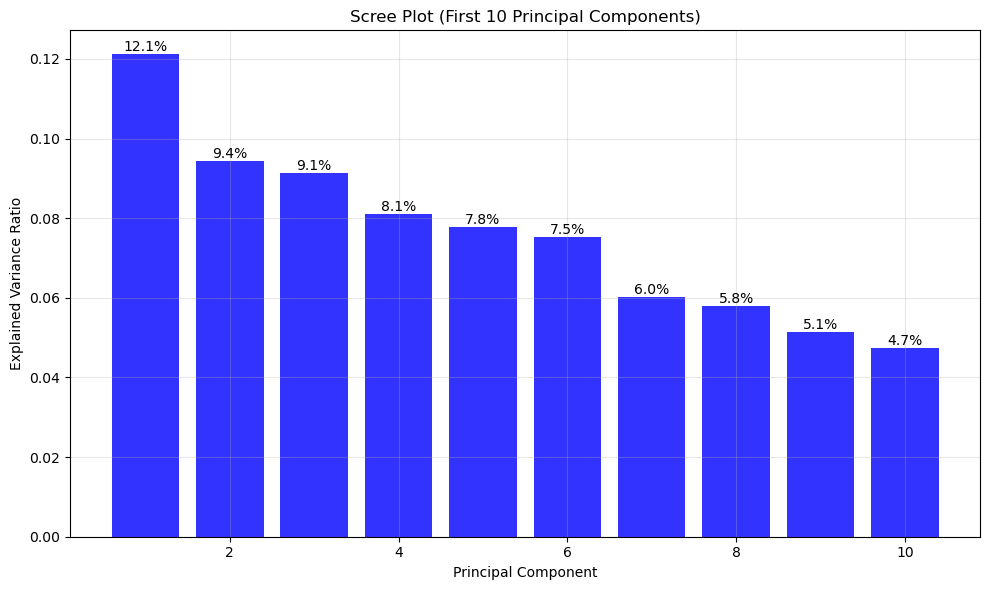

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Convert PyTorch tensors to NumPy arrays and prepare data
feats_np = feats.numpy()
scaler = StandardScaler()
feats_scaled = scaler.fit_transform(feats_np)

# Apply PCA
pca = PCA()
pca.fit(feats_scaled)

# Get first 10 components of explained variance ratio
explained_var_ratio = pca.explained_variance_ratio_[:10]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, 11), explained_var_ratio, alpha=0.8, color='blue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot (First 10 Principal Components)')
plt.grid(True, alpha=0.3)

# Add percentage labels on top of each bar
for i, v in enumerate(explained_var_ratio):
    plt.text(i + 1, v, f'{v*100:.1f}%', ha='center', va='bottom')

# Print cumulative explained variance
cumulative_var = np.cumsum(explained_var_ratio)
print("\nCumulative Explained Variance:")
for i, cum_var in enumerate(cumulative_var, 1):
    print(f"PC1 to PC{i}: {cum_var*100:.1f}%")

plt.tight_layout()
plt.show()

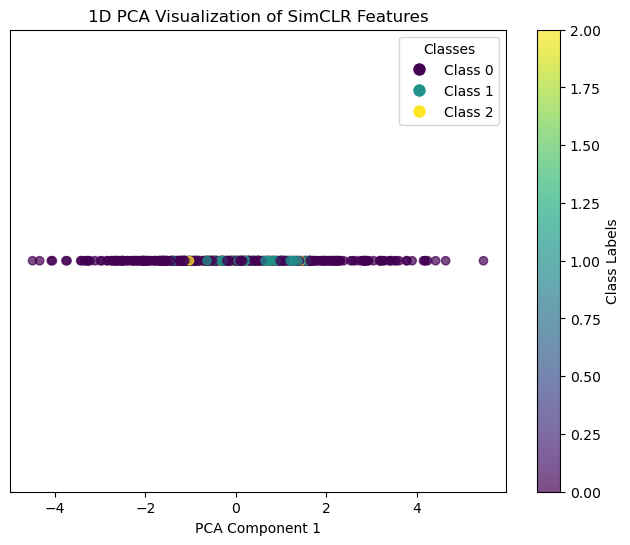

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Convert PyTorch tensors to NumPy arrays
feats_np = feats.numpy()
labels_np = labels.numpy()

# Standardize features before PCA
scaler = StandardScaler()
feats_scaled = scaler.fit_transform(feats_np)

# Apply PCA with 1 component
pca = PCA(n_components=1)
feats_pca = pca.fit_transform(feats_scaled)

# Plot PCA results
plt.figure(figsize=(8, 6))
# Since we have 1D data, we'll use the PCA component for x-axis and create artificial y-coordinates
scatter = plt.scatter(feats_pca, np.zeros_like(feats_pca), c=labels_np, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('')  # No y-axis label needed
plt.title('1D PCA Visualization of SimCLR Features')

# Create legend
unique_labels = np.unique(labels_np)
colors = [scatter.cmap(scatter.norm(label)) for label in unique_labels]
legend_labels = [f'Class {label}' for label in unique_labels]
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors], labels=legend_labels, title='Classes')

# Remove y-axis ticks since they're not meaningful
plt.yticks([])

plt.show()

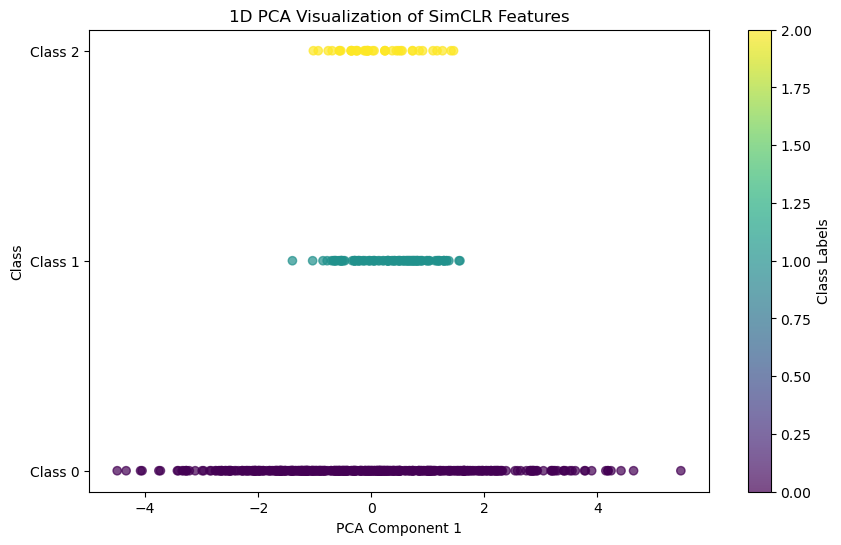

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Convert PyTorch tensors to NumPy arrays
feats_np = feats.numpy()
labels_np = labels.numpy()

# Standardize features before PCA
scaler = StandardScaler()
feats_scaled = scaler.fit_transform(feats_np)

# Apply PCA with 1 component
pca = PCA(n_components=1)
feats_pca = pca.fit_transform(feats_scaled)

# Get unique class labels and assign y-values accordingly
unique_labels = np.unique(labels_np)
class_y_positions = {label: i for i, label in enumerate(unique_labels)}

# Map labels to their respective y positions
y_positions = np.array([class_y_positions[label] for label in labels_np])

# Plot PCA results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(feats_pca, y_positions, c=labels_np, cmap='viridis', alpha=0.7)

# Add colorbar and labels
plt.colorbar(scatter, label='Class Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('Class')
plt.title('1D PCA Visualization of SimCLR Features')

# Set y-ticks to represent class labels
plt.yticks(range(len(unique_labels)), [f'Class {label}' for label in unique_labels])

plt.show()


In [21]:
# Step 1: Find the mean value of PCA 1D for each class
unique_classes = np.unique(labels_np)
class_means = {}

for cls in unique_classes:
    class_pca_values = feats_pca[labels_np == cls]
    class_mean = np.mean(class_pca_values)
    class_means[cls] = class_mean

print("Mean PCA 1D Value for Each Class:")
for cls, mean_val in class_means.items():
    print(f"Class {cls}: {mean_val:.4f}")

# Step 2: Find which class is middle based on mean value (median)
sorted_classes = sorted(class_means.items(), key=lambda x: x[1])
first_class = sorted_classes[0][0]  # Class with the least mean
middle_class = sorted_classes[1][0]  # Middle class
third_class = sorted_classes[2][0]  # Class with the maximum mean
print(f"\nMiddle Class (based on median mean value): Class {middle_class}")

# Step 3: Find min and max value of PCA 1D for each class
class_min_max = {}

for cls in unique_classes:
    class_pca_values = feats_pca[labels_np == cls]
    class_min = np.min(class_pca_values)
    class_max = np.max(class_pca_values)
    class_min_max[cls] = (class_min, class_max)

print("\nMin and Max PCA 1D Values for Each Class:")
for cls, (min_val, max_val) in class_min_max.items():
    print(f"Class {cls}: Min = {min_val:.4f}, Max = {max_val:.4f}")

# Step 4: Number of data points from first class that passed the minimum value of PCA 1D of the middle class
middle_class_min = class_min_max[middle_class][0]
first_class_values = feats_pca[labels_np == first_class]
first_class_pass_count = np.sum(first_class_values > middle_class_min)
print(f"\nNumber of data points from Class {first_class} that passed the minimum value of Middle Class: {first_class_pass_count}")

# Step 5: Number of data points from third class that lies before the maximum value of PCA 1D of the middle class
middle_class_max = class_min_max[middle_class][1]
third_class_values = feats_pca[labels_np == third_class]
third_class_before_count = np.sum(third_class_values < middle_class_max)
print(f"Number of data points from Class {third_class} that lies before the maximum value of Middle Class: {third_class_before_count}")

# Step 6: Calculate accuracy
total_other_class_points_in_middle_range = first_class_pass_count + third_class_before_count
total_datapoints = len(feats_pca)
accuracy = (total_datapoints - total_other_class_points_in_middle_range) / total_datapoints
print(f"\nAccuracy: {accuracy:.4f}")


Mean PCA 1D Value for Each Class:
Class 0: -0.0825
Class 1: 0.3307
Class 2: 0.1224

Middle Class (based on median mean value): Class 2

Min and Max PCA 1D Values for Each Class:
Class 0: Min = -4.4953, Max = 5.4759
Class 1: Min = -1.3960, Max = 1.5684
Class 2: Min = -1.0257, Max = 1.4549

Number of data points from Class 0 that passed the minimum value of Middle Class: 319
Number of data points from Class 1 that lies before the maximum value of Middle Class: 101

Accuracy: 0.3171


In [22]:
s

NameError: name 's' is not defined

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize

# Convert PyTorch tensors to NumPy arrays
feats_np = feats.numpy()
labels_np = labels.numpy()

# Normalize features
feats_np_norm = normalize(feats_np, axis=1)

# Standardize features before PCA
scaler = StandardScaler()
feats_scaled = scaler.fit_transform(feats_np_norm)

# Apply PCA
pca = PCA(n_components=2)
feats_pca = pca.fit_transform(feats_scaled)

# Plot PCA results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feats_pca[:, 0], feats_pca[:, 1], c=labels_np, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of SimCLR Features')

# Create legend
unique_labels = np.unique(labels_np)
colors = [scatter.cmap(scatter.norm(label)) for label in unique_labels]
legend_labels = [f'Class {label}' for label in unique_labels]
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors], labels=legend_labels, title='Classes')

plt.show()


In [34]:
type(feats)

torch.Tensor

# Extract features for train and test datasets
feats_simclr = prepare_data_features(simclr_model, loader_labeled)

In [35]:
"""# Convert features and labels to NumPy arrays
feats_np = feats_simclr.tensors[0].numpy()  # Features in shape (60, 512)

labels_np = feats_simclr.tensors[1].numpy()  # Corresponding labels"""

feats_np = feats.numpy()
labels_np = labels.numpy()

# Check the shapes
print("Shape of features (for K-Means):", feats_np.shape)
print("Shape of labels:", labels_np.shape)

Shape of features (for K-Means): (615, 20)
Shape of labels: (615,)


In [36]:
from sklearn.preprocessing import normalize

In [37]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to reduce to 2D using PCA
def reduce_to_2D_pca(X, centroids):
    pca = PCA(n_components=2)
    X_2D = pca.fit_transform(X)  # Reducing original data points
    centroids_2D = pca.transform(centroids)  # Reducing centroids

    return X_2D, centroids_2D

# Function to plot 2D clusters with centroids and true labels
def plot_2D_clusters_with_labels(X_2D, centroids_2D, idx, labels, K):
    plt.figure(figsize=(8, 6))
    
    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_2D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster
        
        # Scatter plot for each cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6, s=20)
        
        # Annotate each point with its true label
        for i in range(len(cluster_points)):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i, 0], cluster_points[i, 1]), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    for k in range(K):
        plt.scatter(centroids_2D[k, 0], centroids_2D[k, 1], 
                    c='k', marker='x', s=200, label=f'Centroid {k+1}' if k == 0 else "")

    plt.title("2D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid()
    plt.show()

# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(feats_np_norm, best_centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, best_idx, labels_np, K)


NameError: name 'feats_np_norm' is not defined

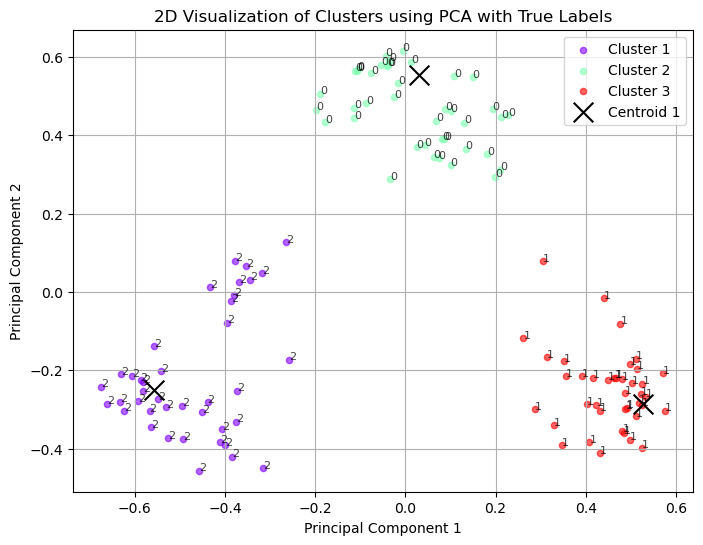

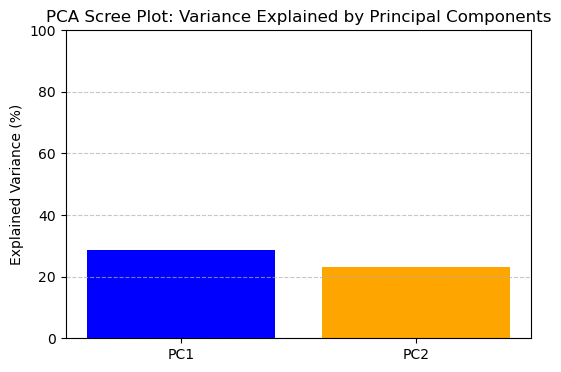

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to reduce to 2D using PCA and return explained variance
def reduce_to_2D_pca(X, centroids):
    pca = PCA(n_components=2)
    X_2D = pca.fit_transform(X)  # Reducing original data points
    centroids_2D = pca.transform(centroids)  # Reducing centroids
    explained_variance = pca.explained_variance_ratio_  # Explained variance for the first two PCs

    return X_2D, centroids_2D, explained_variance

# Function to plot PCA scree plot
def plot_pca_scree(explained_variance):
    plt.figure(figsize=(6, 4))
    plt.bar(["PC1", "PC2"], explained_variance * 100, color=['blue', 'orange'])
    plt.ylabel("Explained Variance (%)")
    plt.title("PCA Scree Plot: Variance Explained by Principal Components")
    plt.ylim(0, 100)  # Limit to 100% for better visualization
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca, explained_variance_pca = reduce_to_2D_pca(feats_np_norm, best_centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, best_idx, labels_np, K)

# Plot PCA Scree Plot
plot_pca_scree(explained_variance_pca)


In [33]:
print(f"Explained Variance Ratio - PC1: {explained_variance_pca[0]:.4f}, PC2: {explained_variance_pca[1]:.4f}")


Explained Variance Ratio - PC1: 0.2860, PC2: 0.2309


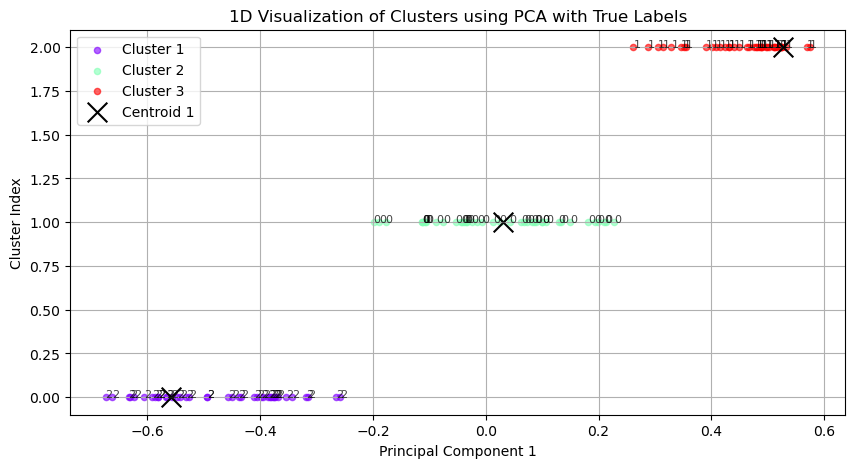


1D PCA values in ascending order: [-0.67422354 -0.6618506  -0.63328415 -0.63090384 -0.6232822  -0.6050955
 -0.59161615 -0.58710814 -0.5817171  -0.5816232  -0.5671112  -0.5644147
 -0.5570517  -0.5475627  -0.54161656 -0.5309715  -0.5261008  -0.49478018
 -0.49377307 -0.45689332 -0.44976163 -0.43842104 -0.433227   -0.41051653
 -0.406223   -0.3989715  -0.39519322 -0.38608617 -0.3834336  -0.38045263
 -0.37674323 -0.37528268 -0.37380263 -0.36921185 -0.35411978 -0.3440262
 -0.31818148 -0.315335   -0.26533034 -0.25883582 -0.19865803 -0.1891391
 -0.17756371 -0.11318383 -0.11306266 -0.11083626 -0.10778275 -0.10614646
 -0.08753853 -0.07616495 -0.05343712 -0.04390974 -0.04132077 -0.03795398
 -0.03555905 -0.03353995 -0.02524958 -0.01587157 -0.00607888  0.01255174
  0.02466077  0.04244286  0.06228642  0.06839561  0.07360953  0.08137137
  0.08619266  0.08853185  0.10009573  0.10011639  0.10764465  0.1292649
  0.13330436  0.1491074   0.18082166  0.19298589  0.19844873  0.20968878
  0.2124299   0.22756

In [28]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Function to reduce the dimensionality of data points and centroids to 1D using PCA
def reduce_to_1D_pca(X, centroids):
    # Initialize PCA with 1 component
    pca = PCA(n_components=1)
    
    # Apply PCA to the data points (X) and centroids
    X_1D = pca.fit_transform(X)  # Reducing original data points
    centroids_1D = pca.transform(centroids)  # Reducing centroids

    return X_1D, centroids_1D

# Function to plot 1D visualization of clustered data points and centroids with true labels
def plot_1D_clusters_with_labels(X_1D, centroids_1D, idx, labels, K):
    plt.figure(figsize=(10, 5))
    
    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_1D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster
        
        # Scatter plot for each cluster
        plt.scatter(cluster_points, [k] * len(cluster_points), 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6, s=20)
        
        # Annotate each point with its true label
        for i in range(len(cluster_points)):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i], k), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    for k in range(K):
        plt.scatter(centroids_1D[k], k, 
                    c='k', marker='x', s=200, label=f'Centroid {k+1}' if k == 0 else "")

    plt.title("1D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Cluster Index")
    plt.legend()
    plt.grid()
    plt.show()

# Apply PCA after K-Means clustering for 1D visualization
X_1D_pca, centroids_1D_pca = reduce_to_1D_pca(feats_np_norm, best_centroids)

# Plot the 1D clusters with centroids and true labels
plot_1D_clusters_with_labels(X_1D_pca, centroids_1D_pca, best_idx, labels_np, K)

# Print the 1D values (PCA scores) in ascending order
sorted_X_1D = np.sort(X_1D_pca.flatten())  # Flatten and sort the PCA scores
print("\n1D PCA values in ascending order:", sorted_X_1D)

# Sort the 1D centroid values and map to labels
sorted_centroids_idx = np.argsort(centroids_1D_pca.flatten())
true_labels_mapping = ['control', 'sd', 'ex']
sorted_labels = [true_labels_mapping[i] for i in sorted_centroids_idx]

# Print sorted centroids with their corresponding true labels
print("\nCentroids in ascending order:")
for i, idx in enumerate(sorted_centroids_idx):
    print(f"Centroid {i+1}: {sorted_labels[i]}, Value: {centroids_1D_pca[idx][0]:.4f}")


Sorted PCA values with corresponding paths and true labels:
PCA value: -0.6742, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g8_B11-T01.tiff
PCA value: -0.6619, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g6_F02-T01.tiff
PCA value: -0.6333, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g9_C11-T01.tiff
PCA value: -0.6309, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g6_F03-T01.tiff
PCA value: -0.6233, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g8_B10-T01.tiff
PCA value: -0.6051, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g8_B07-T01.tiff
PCA value: -0.5916, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g9_C10-T01.tiff
PCA value: -0.5871, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g9_C08-T01.tiff
PCA value: -0.5817, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g8_B09-T01.tiff
PCA value: -0.5816, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g6_F06-T01.tiff
PCA value: -0.5671, Label: ex, Path: G:\cluster_40\cure\ex\ds62_g8_B10-T01.tiff
PCA value: -0.5644, Label: ex, Path: G:\cluster_40\cure\ex\

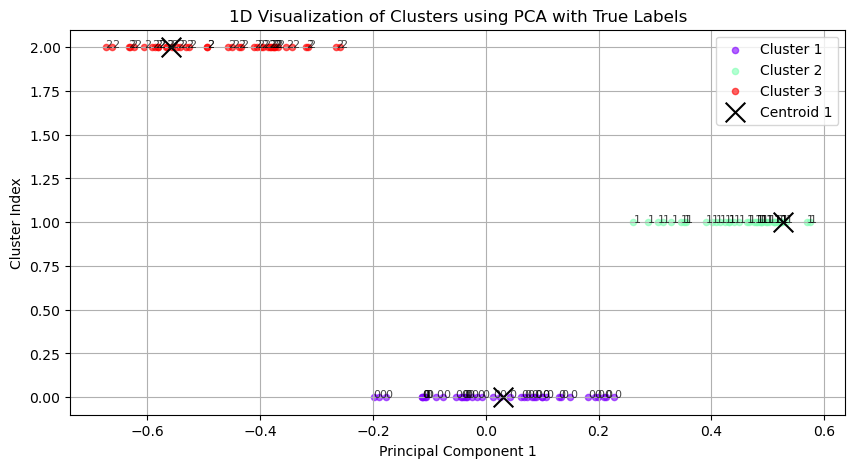

In [29]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import mode

def reduce_to_1D_pca(X, centroids):
    pca = PCA(n_components=1)
    X_1D = pca.fit_transform(X)
    centroids_1D = pca.transform(centroids)
    return X_1D, centroids_1D

def plot_1D_clusters_with_labels(X_1D, centroids_1D, idx, labels, K):
    plt.figure(figsize=(10, 5))
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    for k in range(K):
        cluster_points = X_1D[idx == k]
        cluster_labels = labels[idx == k]
        
        plt.scatter(cluster_points, [k] * len(cluster_points), 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6, s=20)
        
        for i in range(len(cluster_points)):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i], k), 
                         fontsize=8, alpha=0.75)

    for k in range(K):
        plt.scatter(centroids_1D[k], k, 
                    c='k', marker='x', s=200, label=f'Centroid {k+1}' if k == 0 else "")

    plt.title("1D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Cluster Index")
    plt.legend()
    plt.grid()
    plt.show()

# Normalize features
feats_np_norm = normalize(feats_np, axis=1)

# Run clustering (using your existing cosine distance K-means code)
K = 3
best_centroids, best_idx, best_accuracy, accuracies = perform_clustering(feats_np_norm, K)

# Apply PCA and get sorted indices with paths
X_1D_pca, centroids_1D_pca = reduce_to_1D_pca(feats_np_norm, best_centroids)

# Create a list of tuples containing (PCA value, path, true_label)
pca_path_pairs = list(zip(X_1D_pca.flatten(), paths, labels_np))

# Sort based on PCA values while keeping track of paths and labels
sorted_pca_path_pairs = sorted(pca_path_pairs, key=lambda x: x[0])

# Separate sorted values, paths, and labels
sorted_X_1D = np.array([x[0] for x in sorted_pca_path_pairs])
sorted_paths = [x[1] for x in sorted_pca_path_pairs]
sorted_true_labels = [x[2] for x in sorted_pca_path_pairs]

# Print values with corresponding paths and true labels
print("\nSorted PCA values with corresponding paths and true labels:")
true_labels_mapping = ['control', 'sd', 'ex']
for pca_val, path, label in zip(sorted_X_1D, sorted_paths, sorted_true_labels):
    print(f"PCA value: {pca_val:.4f}, Label: {true_labels_mapping[label]}, Path: {path}")

# Print centroid information
sorted_centroids_idx = np.argsort(centroids_1D_pca.flatten())
sorted_labels = [true_labels_mapping[i] for i in sorted_centroids_idx]

print("\nCentroids in ascending order:")
for i, idx in enumerate(sorted_centroids_idx):
    print(f"Centroid {i+1}: {sorted_labels[i]}, Value: {centroids_1D_pca[idx][0]:.4f}")

# Plot the visualization
plot_1D_clusters_with_labels(X_1D_pca, centroids_1D_pca, best_idx, labels_np, K)

weighted pca

In [30]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Function to reduce to 2D PCA and compute weighted 1D metric
def reduce_to_weighted_1D_pca(X, centroids):
    pca = PCA(n_components=2)
    X_2D = pca.fit_transform(X)
    centroids_2D = pca.transform(centroids)
    
    # Get explained variance ratios as weights
    explained_variance = pca.explained_variance_ratio_
    w1, w2 = explained_variance[0], explained_variance[1]
    
    # Compute the weighted 1D metric
    X_weighted_1D = w1 * X_2D[:, 0] + w2 * X_2D[:, 1]
    centroids_weighted_1D = w1 * centroids_2D[:, 0] + w2 * centroids_2D[:, 1]
    
    return X_weighted_1D, centroids_weighted_1D

# Apply PCA and compute weighted 1D metric
X_weighted_1D, centroids_weighted_1D = reduce_to_weighted_1D_pca(feats_np_norm, best_centroids)

# Create a list of tuples containing (Weighted PCA value, path, true_label)
pca_path_pairs = list(zip(X_weighted_1D, paths, labels_np))

# Sort based on the weighted PCA values
sorted_pca_path_pairs = sorted(pca_path_pairs, key=lambda x: x[0])

# Separate sorted values, paths, and labels
sorted_weighted_X_1D = np.array([x[0] for x in sorted_pca_path_pairs])
sorted_paths = [x[1] for x in sorted_pca_path_pairs]
sorted_true_labels = [x[2] for x in sorted_pca_path_pairs]

# Print sorted weighted PCA values with corresponding paths and true labels
true_labels_mapping = ['control', 'sd', 'ex']
print("\nSorted Weighted PCA values with corresponding paths and true labels:")
for pca_val, path, label in zip(sorted_weighted_X_1D, sorted_paths, sorted_true_labels):
    print(f"Weighted PCA value: {pca_val:.4f}, Label: {true_labels_mapping[label]}, Path: {path}")

# Print centroid information
sorted_centroids_idx = np.argsort(centroids_weighted_1D)
sorted_labels = [true_labels_mapping[i] for i in sorted_centroids_idx]

print("\nCentroids in ascending order:")
for i, idx in enumerate(sorted_centroids_idx):
    print(f"Centroid {i+1}: {sorted_labels[i]}, Value: {centroids_weighted_1D[idx]:.4f}")



Sorted Weighted PCA values with corresponding paths and true labels:
Weighted PCA value: -0.2551, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g6_F02-T01.tiff
Weighted PCA value: -0.2486, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g8_B11-T01.tiff
Weighted PCA value: -0.2482, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g8_B10-T01.tiff
Weighted PCA value: -0.2459, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g9_C11-T01.tiff
Weighted PCA value: -0.2410, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g6_F05-T01.tiff
Weighted PCA value: -0.2368, Label: ex, Path: G:\cluster_40\cure\ex\ds62_g9_C11-T01.tiff
Weighted PCA value: -0.2360, Label: ex, Path: G:\cluster_40\cure\ex\ds62_g8_B07-T01.tiff
Weighted PCA value: -0.2337, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g9_C10-T01.tiff
Weighted PCA value: -0.2324, Label: ex, Path: G:\cluster_40\cure\ex\ds62_g8_B10-T01.tiff
Weighted PCA value: -0.2288, Label: ex, Path: G:\cluster_40\cure\ex\ds61_g6_F03-T01.tiff
Weighted PCA value: -0.2281, Label: ex, 

In [31]:
import numpy as np

def calculate_middle_cluster_accuracy(X_1D, idx, centroids_1D):
    # Convert idx to array if it's not already
    if not isinstance(idx, np.ndarray):
        idx = np.array(idx)
    
    # Ensure idx is the same length as X_1D
    if idx.shape != (len(X_1D),):
        print("Warning: Reshaping idx to match data points")
        idx = np.full(len(X_1D), idx)
    
    print("Debugging Information:")
    print(f"Shape of X_1D: {X_1D.shape}")
    print(f"Shape of idx (after fix): {idx.shape}")
    print(f"Shape of centroids_1D: {centroids_1D.shape}")
    print(f"Unique cluster indices: {np.unique(idx)}")
    
    # Sort centroids and get their indices
    centroid_values = centroids_1D.flatten()
    sorted_indices = np.argsort(centroid_values)
    print(f"Centroid values: {centroid_values}")
    print(f"Sorted centroid indices: {sorted_indices}")
    
    # Map old cluster indices to new ordered indices (0, 1, 2)
    index_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}
    
    # Reindex the clusters to be 0, 1, 2 in order of centroid values
    new_idx = np.zeros_like(idx)
    for old_idx, new_idx_val in index_mapping.items():
        new_idx[idx == old_idx] = new_idx_val
    
    # Now we work with the reindexed clusters
    # Get points belonging to each cluster
    first_cluster_points = X_1D[new_idx == 0]
    middle_cluster_points = X_1D[new_idx == 1]
    third_cluster_points = X_1D[new_idx == 2]
    
    print(f"\nCluster sizes after reindexing:")
    print(f"First cluster points: {len(first_cluster_points)}")
    print(f"Middle cluster points: {len(middle_cluster_points)}")
    print(f"Third cluster points: {len(third_cluster_points)}")
    
    # Check if any clusters are empty
    if len(first_cluster_points) == 0 or len(middle_cluster_points) == 0 or len(third_cluster_points) == 0:
        raise ValueError("One or more clusters are empty after reindexing. Please check cluster assignments.")
    
    # Calculate boundary values
    first_cluster_max = np.max(first_cluster_points)
    third_cluster_min = np.min(third_cluster_points)
    
    # Count errors
    errors_below = np.sum(middle_cluster_points < first_cluster_max)
    errors_above = np.sum(middle_cluster_points > third_cluster_min)
    total_errors = errors_below + errors_above
    total_points = 40+40+40
    # Calculate accuracy
    total_middle_points = len(middle_cluster_points)
    accuracy = (total_points - total_errors) / total_points
    
    # Print boundary information
    print(f"\nBoundary Information:")
    print(f"First cluster range: [{np.min(first_cluster_points):.4f}, {first_cluster_max:.4f}]")
    print(f"Middle cluster range: [{np.min(middle_cluster_points):.4f}, {np.max(middle_cluster_points):.4f}]")
    print(f"Third cluster range: [{third_cluster_min:.4f}, {np.max(third_cluster_points):.4f}]")
    
    return {
        'accuracy': accuracy,
        'total_points': total_middle_points,
        'errors_below': errors_below,
        'errors_above': errors_above,
        'total_errors': total_errors,
        'first_cluster_max': first_cluster_max,
        'third_cluster_min': third_cluster_min
    }

# Try to calculate the accuracy metrics with error handling
try:
    # Use best_idx from our successful K-means clustering
    results = calculate_middle_cluster_accuracy(X_1D_pca, best_idx, centroids_1D_pca)
    
    print(f"\nResults:")
    print(f"Total points in middle cluster: {results['total_points']}")
    print(f"Errors below first cluster max: {results['errors_below']}")
    print(f"Errors above third cluster min: {results['errors_above']}")
    print(f"Total errors: {results['total_errors']}")
    print(f"Accuracy: {results['accuracy']:.4f} ({results['accuracy']*100:.2f}%)")
    
except ValueError as e:
    print(f"Error: {e}")
    print("Additional debugging needed. Please check:")
    print("1. The original cluster assignments")
    print("2. The K-means clustering results")
    print("3. The PCA transformation process")

Debugging Information:
Shape of X_1D: (120, 1)
Shape of idx (after fix): (120,)
Shape of centroids_1D: (3, 1)
Unique cluster indices: [0 1 2]
Centroid values: [ 0.03042284  0.52752201 -0.55725242]
Sorted centroid indices: [2 0 1]

Cluster sizes after reindexing:
First cluster points: 40
Middle cluster points: 40
Third cluster points: 40

Boundary Information:
First cluster range: [-0.6742, -0.2588]
Middle cluster range: [-0.1987, 0.2276]
Third cluster range: [0.2616, 0.5749]

Results:
Total points in middle cluster: 40
Errors below first cluster max: 0
Errors above third cluster min: 0
Total errors: 0
Accuracy: 1.0000 (100.00%)


In [32]:
import numpy as np

def calculate_cluster_accuracy_both_metrics(X_1D, idx, centroids_1D):
    # Convert idx to array if it's not already
    if not isinstance(idx, np.ndarray):
        idx = np.array(idx)
    
    # Ensure idx is the same length as X_1D
    if idx.shape != (len(X_1D),):
        print("Warning: Reshaping idx to match data points")
        idx = np.full(len(X_1D), idx)
    
    print("Debugging Information:")
    print(f"Shape of X_1D: {X_1D.shape}")
    print(f"Shape of idx (after fix): {idx.shape}")
    print(f"Shape of centroids_1D: {centroids_1D.shape}")
    print(f"Unique cluster indices: {np.unique(idx)}")
    
    # Sort centroids and get their indices
    centroid_values = centroids_1D.flatten()
    sorted_indices = np.argsort(centroid_values)
    print(f"Centroid values: {centroid_values}")
    print(f"Sorted centroid indices: {sorted_indices}")
    
    # Map old cluster indices to new ordered indices (0, 1, 2)
    index_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}
    
    # Reindex the clusters to be 0, 1, 2 in order of centroid values
    new_idx = np.zeros_like(idx)
    for old_idx, new_idx_val in index_mapping.items():
        new_idx[idx == old_idx] = new_idx_val
    
    # Now we work with the reindexed clusters
    # Get points belonging to each cluster
    first_cluster_points = X_1D[new_idx == 0]
    middle_cluster_points = X_1D[new_idx == 1]
    third_cluster_points = X_1D[new_idx == 2]
    
    print(f"\nCluster sizes after reindexing:")
    print(f"First cluster points: {len(first_cluster_points)}")
    print(f"Middle cluster points: {len(middle_cluster_points)}")
    print(f"Third cluster points: {len(third_cluster_points)}")
    
    # Check if any clusters are empty
    if len(first_cluster_points) == 0 or len(middle_cluster_points) == 0 or len(third_cluster_points) == 0:
        raise ValueError("One or more clusters are empty after reindexing. Please check cluster assignments.")
    
    # Calculate boundary values for original metric
    first_cluster_max = np.max(first_cluster_points)
    third_cluster_min = np.min(third_cluster_points)
    
    # Calculate boundary values for new metric
    middle_cluster_min = np.min(middle_cluster_points)
    middle_cluster_max = np.max(middle_cluster_points)
    
    # Count errors for original metric (middle cluster errors)
    middle_errors_below = np.sum(middle_cluster_points < first_cluster_max)
    middle_errors_above = np.sum(middle_cluster_points > third_cluster_min)
    total_middle_errors = middle_errors_below + middle_errors_above
    
    # Count errors for new metric (outer clusters errors)
    first_cluster_errors = np.sum(first_cluster_points > middle_cluster_min)
    third_cluster_errors = np.sum(third_cluster_points < middle_cluster_max)
    total_outer_errors = first_cluster_errors + third_cluster_errors
    
    total_points = len(first_cluster_points) + len(middle_cluster_points) + len(third_cluster_points)
    
    # Calculate accuracies
    middle_accuracy = (total_points - total_middle_errors) / total_points
    outer_accuracy = (total_points - total_outer_errors) / total_points
    
    # Print boundary information
    print(f"\nBoundary Information:")
    print(f"First cluster range: [{np.min(first_cluster_points):.4f}, {first_cluster_max:.4f}]")
    print(f"Middle cluster range: [{middle_cluster_min:.4f}, {middle_cluster_max:.4f}]")
    print(f"Third cluster range: [{third_cluster_min:.4f}, {np.max(third_cluster_points):.4f}]")
    
    # Print detailed error counts for debugging
    print("\nDetailed Error Analysis:")
    print("Original Metric (Middle cluster errors):")
    print(f"Middle points below first max: {middle_errors_below}")
    print(f"Middle points above third min: {middle_errors_above}")
    print("\nNew Metric (Outer clusters errors):")
    print(f"First cluster points above middle min: {first_cluster_errors}")
    print(f"Third cluster points below middle max: {third_cluster_errors}")
    
    return {
        # Original metric results
        'middle_accuracy': middle_accuracy,
        'middle_errors_below': middle_errors_below,
        'middle_errors_above': middle_errors_above,
        'total_middle_errors': total_middle_errors,
        
        # New metric results
        'outer_accuracy': outer_accuracy,
        'first_cluster_errors': first_cluster_errors,
        'third_cluster_errors': third_cluster_errors,
        'total_outer_errors': total_outer_errors,
        
        # Boundary values
        'first_cluster_max': first_cluster_max,
        'middle_cluster_min': middle_cluster_min,
        'middle_cluster_max': middle_cluster_max,
        'third_cluster_min': third_cluster_min,
        
        'total_points': total_points
    }

# Try to calculate both accuracy metrics with error handling
try:
    # Use best_idx from the K-means clustering
    results = calculate_cluster_accuracy_both_metrics(X_1D_pca, best_idx, centroids_1D_pca)
    
    print(f"\nFinal Results:")
    print("\nOriginal Metric (Middle cluster errors):")
    print(f"Total errors: {results['total_middle_errors']}")
    print(f"Accuracy: {results['middle_accuracy']:.4f} ({results['middle_accuracy']*100:.2f}%)")
    
    print("\nNew Metric (Outer clusters errors):")
    print(f"Total errors: {results['total_outer_errors']}")
    print(f"Accuracy: {results['outer_accuracy']:.4f} ({results['outer_accuracy']*100:.2f}%)")
    
except ValueError as e:
    print(f"Error: {e}")
    print("Additional debugging needed. Please check:")
    print("1. The original cluster assignments")
    print("2. The K-means clustering results")
    print("3. The PCA transformation process")

Debugging Information:
Shape of X_1D: (120, 1)
Shape of idx (after fix): (120,)
Shape of centroids_1D: (3, 1)
Unique cluster indices: [0 1 2]
Centroid values: [ 0.03042284  0.52752201 -0.55725242]
Sorted centroid indices: [2 0 1]

Cluster sizes after reindexing:
First cluster points: 40
Middle cluster points: 40
Third cluster points: 40

Boundary Information:
First cluster range: [-0.6742, -0.2588]
Middle cluster range: [-0.1987, 0.2276]
Third cluster range: [0.2616, 0.5749]

Detailed Error Analysis:
Original Metric (Middle cluster errors):
Middle points below first max: 0
Middle points above third min: 0

New Metric (Outer clusters errors):
First cluster points above middle min: 0
Third cluster points below middle max: 0

Final Results:

Original Metric (Middle cluster errors):
Total errors: 0
Accuracy: 1.0000 (100.00%)

New Metric (Outer clusters errors):
Total errors: 0
Accuracy: 1.0000 (100.00%)


# Function to reduce the dimensionality of data points and centroids to 2D using PCA
def reduce_to_2D_pca(X, centroids):
    # Initialize PCA with 2 components
    pca = PCA(n_components=2)
    
    # Apply PCA to the data points (X) and centroids
    X_2D = pca.fit_transform(X)  # Reducing original data points
    centroids_2D = pca.transform(centroids)  # Reducing centroids

    return X_2D, centroids_2D

# Function to plot 2D visualization of clustered data points and centroids with true labels
def plot_2D_clusters_with_labels(X_2D, centroids_2D, idx, labels, K):
    plt.figure(figsize=(10, 7))
    
    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_2D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster
        
        # Scatter plot for each cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6)
        
        # Annotate each point with its true label
        for i in range(cluster_points.shape[0]):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i, 0], cluster_points[i, 1]), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], 
                c='k', marker='x', s=200, label='Centroids')

    plt.title("2D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid()
    plt.show()


# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(feats_np_norm, centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, idx, labels_np, K)
